Задача состоит в многоклассовой классификации изображений на 10 категорий. 
Необходимо построить модель, которая сможет классифицировать изображения размером 32x32 пикселя с 3 цветовыми каналами (RGB) на классы: 
самолет, автомобиль, птица, кошка, олень, собака, лягушка, лошадь, корабль, грузовик.

In [6]:
!pip install tensorflow pandas numpy scikit-learn matplotlib seaborn

  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 1.6/332.0 MB 10.7 MB/s eta 0:00:31
   ---------------------------------------- 3.4/332.0 MB 10.8 MB/s eta 0:00:31
    --------------------------------------- 6.3/332.0 MB 11.6 MB/s eta 0:00:29
   - -------------------------------------- 8.7/332.0 MB 11.4 MB/s eta 0:00:29
   - -------------------------------------- 11.3/332.0 MB 11.5 MB/s eta 0:00:28
   - -------------------------------------- 13.6/332.0 MB 11.5 MB/s eta 0:00:28
   - -------------------------------------- 16.0/332.0 MB 11.6 MB/s eta 0:00:28
   -- ------------------------------------- 18.4/332.0 MB 11.6 MB/s eta 0:00:28
   -- ------------------------------------- 21.0/332.0 MB 11.6 MB/s eta 0:00:27
   -- ------------------------------------- 23.3/332.0 MB 11.6 MB/s eta 0


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**1. Прочитать данные**

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Загрузка CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print("Форма данных:")
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step
Форма данных:
x_train: (50000, 32, 32, 3)
y_train: (50000, 1)
x_test: (10000, 32, 32, 3)
y_test: (10000, 1)


**2. Разбиение данных на обучающую и тестовую выборки**

In [8]:
# Данные уже разделены на train/test при загрузке
print(f"Обучающая выборка: {x_train.shape[0]} изображений")
print(f"Тестовая выборка: {x_test.shape[0]} изображений")

# Для KNN преобразуем данные в 2D
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

print(f"\nПосле преобразования в 2D:")
print(f"x_train_flat: {x_train_flat.shape}")
print(f"x_test_flat: {x_test_flat.shape}")

Обучающая выборка: 50000 изображений
Тестовая выборка: 10000 изображений

После преобразования в 2D:
x_train_flat: (50000, 3072)
x_test_flat: (10000, 3072)


**3. Визуализация данных и основные характеристики**

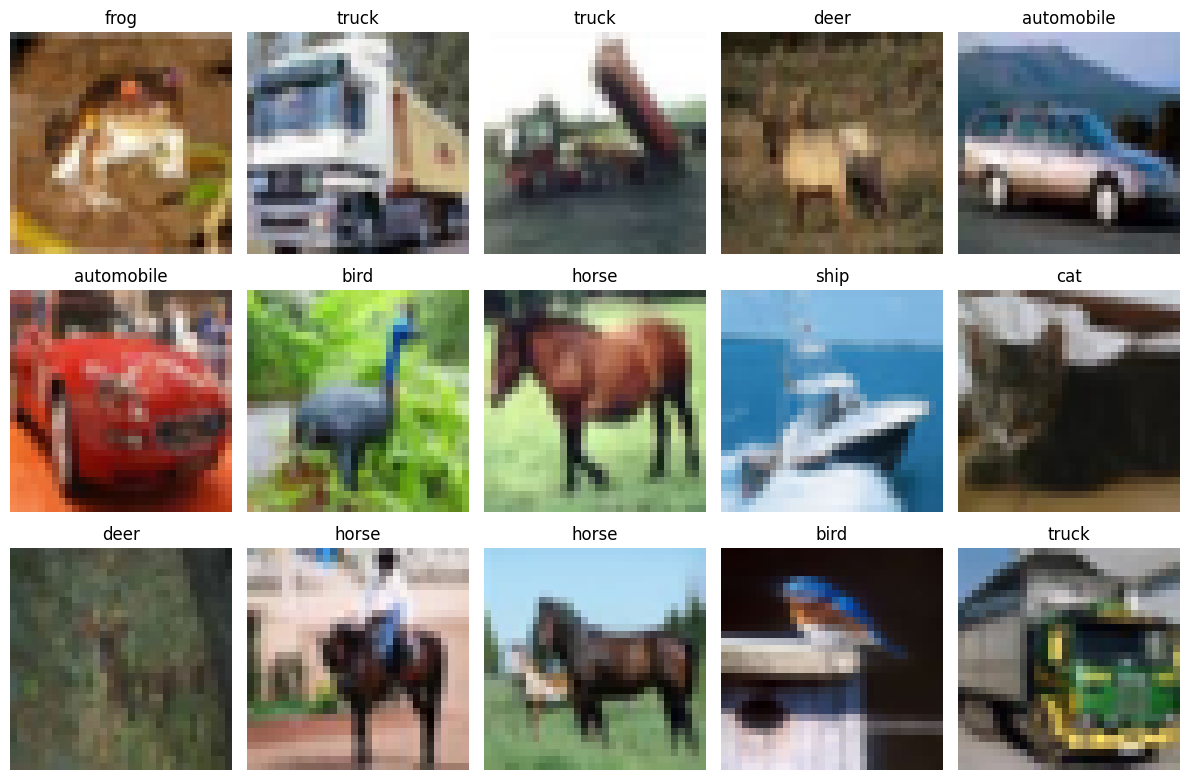

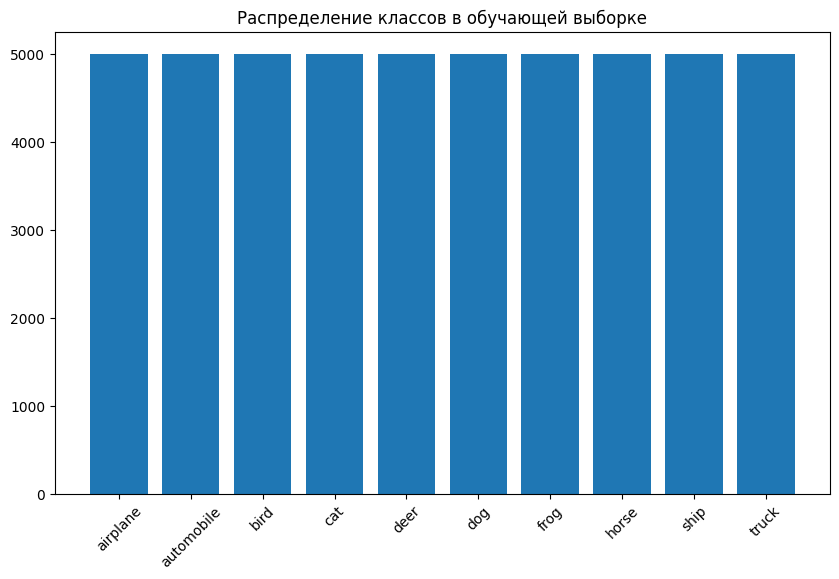

Распределение по классам:
airplane: 5000 изображений (10.0%)
automobile: 5000 изображений (10.0%)
bird: 5000 изображений (10.0%)
cat: 5000 изображений (10.0%)
deer: 5000 изображений (10.0%)
dog: 5000 изображений (10.0%)
frog: 5000 изображений (10.0%)
horse: 5000 изображений (10.0%)
ship: 5000 изображений (10.0%)
truck: 5000 изображений (10.0%)


In [9]:
# Названия классов
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Визуализация примеров изображений
plt.figure(figsize=(12, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f'{class_names[y_train[i][0]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Статистика по классам
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip([class_names[i] for i in unique], counts))

plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Распределение классов в обучающей выборке')
plt.xticks(rotation=45)
plt.show()

print("Распределение по классам:")
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count} изображений ({count/len(y_train)*100:.1f}%)")

In [10]:
# Основные статистические характеристики
print("Основные статистические характеристики:")

# Средние значения по каналам RGB
mean_red = np.mean(x_train[:, :, :, 0])
mean_green = np.mean(x_train[:, :, :, 1])
mean_blue = np.mean(x_train[:, :, :, 2])

print(f"Среднее значение по каналу R: {mean_red:.2f}")
print(f"Среднее значение по каналу G: {mean_green:.2f}")
print(f"Среднее значение по каналу B: {mean_blue:.2f}")

# Стандартные отклонения
std_red = np.std(x_train[:, :, :, 0])
std_green = np.std(x_train[:, :, :, 1])
std_blue = np.std(x_train[:, :, :, 2])

print(f"Стандартное отклонение по каналу R: {std_red:.2f}")
print(f"Стандартное отклонение по каналу G: {std_green:.2f}")
print(f"Стандартное отклонение по каналу B: {std_blue:.2f}")

# Минимальные и максимальные значения
print(f"Минимальное значение пикселя: {x_train.min()}")
print(f"Максимальное значение пикселя: {x_train.max()}")

Основные статистические характеристики:
Среднее значение по каналу R: 125.31
Среднее значение по каналу G: 122.95
Среднее значение по каналу B: 113.87
Стандартное отклонение по каналу R: 62.99
Стандартное отклонение по каналу G: 62.09
Стандартное отклонение по каналу B: 66.70
Минимальное значение пикселя: 0
Максимальное значение пикселя: 255


Интерпретация:

Данные сбалансированы по классам (по 5000 изображений на класс в обучающей выборке)

Изображения имеют размер 32x32 пикселя с 3 цветовыми каналами

Значения пикселей находятся в диапазоне 0-255


In [11]:
# Проверка на пропущенные значения
print("Пропущенные значения в x_train:", np.isnan(x_train).any())
print("Пропущенные значения в y_train:", np.isnan(y_train).any())
print("Пропущенные значения в x_test:", np.isnan(x_test).any())
print("Пропущенные значения в y_test:", np.isnan(y_test).any())

# Проверка на бесконечные значения
print("Бесконечные значения в x_train:", np.isinf(x_train).any())

Пропущенные значения в x_train: False
Пропущенные значения в y_train: False
Пропущенные значения в x_test: False
Пропущенные значения в y_test: False
Бесконечные значения в x_train: False


In [12]:
# Метки уже закодированы числами от 0 до 9
# Преобразуем в one-hot encoding для нейронных сетей (если понадобится)
y_train_categorical = keras.utils.to_categorical(y_train, 10)
y_test_categorical = keras.utils.to_categorical(y_test, 10)

print("One-hot encoded labels shape:", y_train_categorical.shape)

One-hot encoded labels shape: (50000, 10)


In [13]:
# Нормализация значений пикселей от 0-255 к 0-1
x_train_normalized = x_train.astype('float32') / 255.0
x_test_normalized = x_test.astype('float32') / 255.0

# Для KNN также нормализуем flattened данные
x_train_flat_normalized = x_train_flat.astype('float32') / 255.0
x_test_flat_normalized = x_test_flat.astype('float32') / 255.0

print("После нормализации:")
print(f"Диапазон x_train: [{x_train_normalized.min():.3f}, {x_train_normalized.max():.3f}]")

После нормализации:
Диапазон x_train: [0.000, 1.000]


**Объяснение необходимости нормализации:**
Нормализация важна для методов, основанных на расстояниях (как KNN), так как признаки (пиксели) имеют одинаковую природу и масштаб.

In [17]:
# Используем подвыборку для ускорения
sample_size = 5000
indices = np.random.choice(len(x_train_flat_normalized), sample_size, replace=False)
x_train_sample = x_train_flat_normalized[indices]
y_train_sample = y_train_flat[indices]

print(f"Размер подвыборки для KNN: {sample_size}")

# Базовый KNN классификатор
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_sample, y_train_sample)

# Предсказания на тестовой выборке (также используем подвыборку)
test_sample_size = 1000
test_indices = np.random.choice(len(x_test_flat_normalized), test_sample_size, replace=False)
x_test_sample = x_test_flat_normalized[test_indices]
y_test_sample = y_test_flat[test_indices]

y_pred = knn.predict(x_test_sample)

counter = 0
for i in range(len(y_pred)):
    if y_pred[i]==y_test_sample[i]:
        counter+=1

print(f"{5000-i} mistakes")

Размер подвыборки для KNN: 5000
4001 mistakes


KNN плохо работает в качестве алгоритма распознавания изображений

**8. Вычисление ошибок и подбор гиперпараметров**

k=1: Train Accuracy = 1.0000, Test Accuracy = 0.2790
k=3: Train Accuracy = 0.5218, Test Accuracy = 0.2630
k=5: Train Accuracy = 0.4456, Test Accuracy = 0.2720
k=7: Train Accuracy = 0.3996, Test Accuracy = 0.2700
k=10: Train Accuracy = 0.3792, Test Accuracy = 0.2950
k=15: Train Accuracy = 0.3486, Test Accuracy = 0.2930


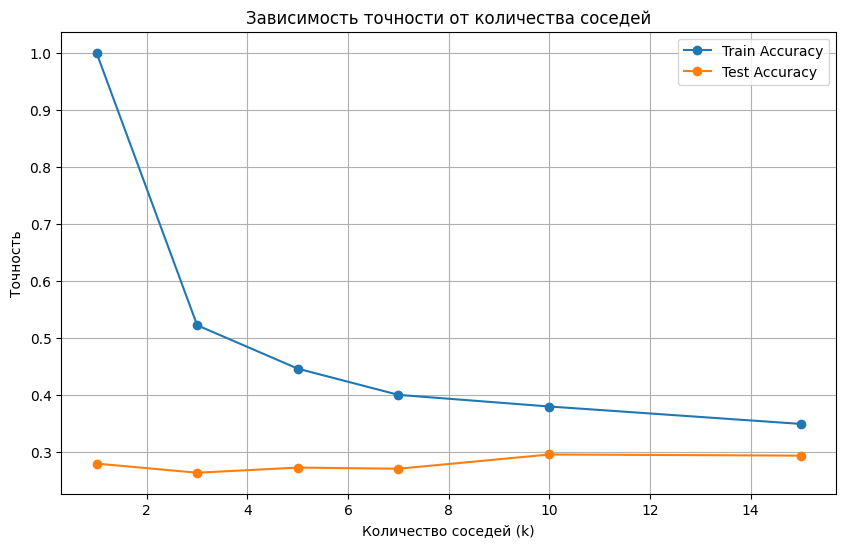

Оптимальное количество соседей: k = 10


In [18]:
# Функция для оценки разных значений k
def evaluate_knn(k_values, x_train, y_train, x_test, y_test):
    train_scores = []
    test_scores = []
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        
        train_score = knn.score(x_train, y_train)
        test_score = knn.score(x_test, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
        
        print(f"k={k}: Train Accuracy = {train_score:.4f}, Test Accuracy = {test_score:.4f}")
    
    return train_scores, test_scores

# Оценка разных значений k
k_values = [1, 3, 5, 7, 10, 15]
train_scores, test_scores = evaluate_knn(k_values, x_train_sample, y_train_sample, x_test_sample, y_test_sample)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, 'o-', label='Train Accuracy')
plt.plot(k_values, test_scores, 'o-', label='Test Accuracy')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.title('Зависимость точности от количества соседей')
plt.legend()
plt.grid(True)
plt.show()

# Выбор оптимального k
best_k = k_values[np.argmax(test_scores)]
print(f"Оптимальное количество соседей: k = {best_k}")

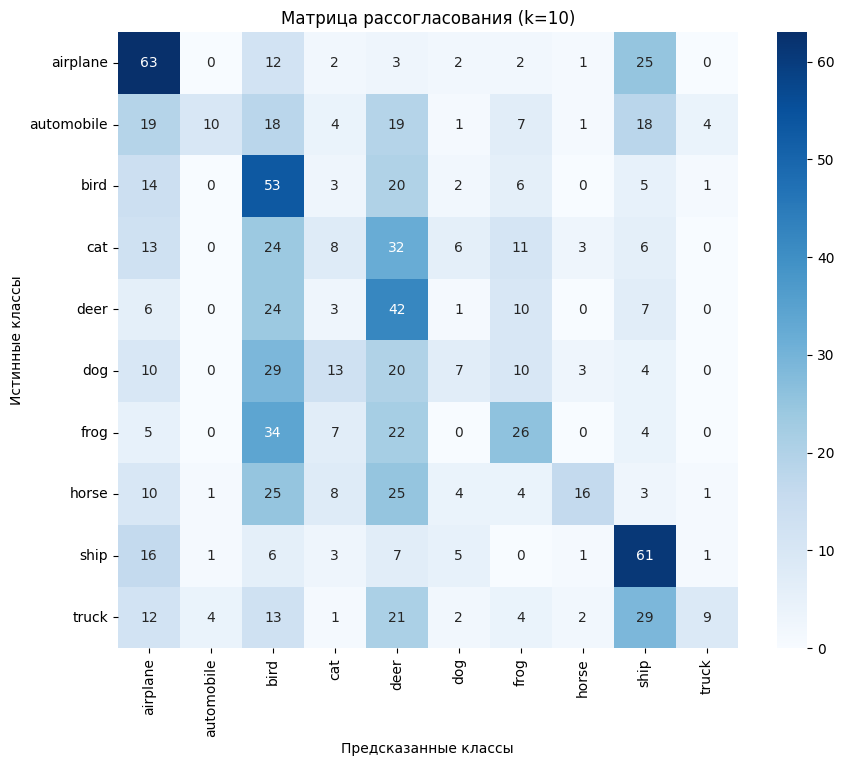

Отчет по классификации:
              precision    recall  f1-score   support

    airplane       0.38      0.57      0.45       110
  automobile       0.62      0.10      0.17       101
        bird       0.22      0.51      0.31       104
         cat       0.15      0.08      0.10       103
        deer       0.20      0.45      0.28        93
         dog       0.23      0.07      0.11        96
        frog       0.33      0.27      0.29        98
       horse       0.59      0.16      0.26        97
        ship       0.38      0.60      0.46       101
       truck       0.56      0.09      0.16        97

    accuracy                           0.29      1000
   macro avg       0.37      0.29      0.26      1000
weighted avg       0.37      0.29      0.26      1000

Общая точность на тестовой выборке: 0.2950


In [19]:
# Матрица рассогласования для оптимального k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train_sample, y_train_sample)
y_pred_best = best_knn.predict(x_test_sample)

# Матрица ошибок
cm = confusion_matrix(y_test_sample, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Матрица рассогласования (k={best_k})')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')
plt.show()

# Отчет по классификации
print("Отчет по классификации:")
print(classification_report(y_test_sample, y_pred_best, target_names=class_names))

# Общая точность
accuracy = accuracy_score(y_test_sample, y_pred_best)
print(f"Общая точность на тестовой выборке: {accuracy:.4f}")

**9. Сравнение с другими классификаторами**

Объясненная дисперсия PCA: 0.9045

Обучение KNN...
KNN точность: 0.3270

Обучение Logistic Regression...
Logistic Regression точность: 0.3740

Обучение Random Forest...
Random Forest точность: 0.3880

Обучение Naive Bayes...
Naive Bayes точность: 0.2780

Обучение SVM...
SVM точность: 0.3630


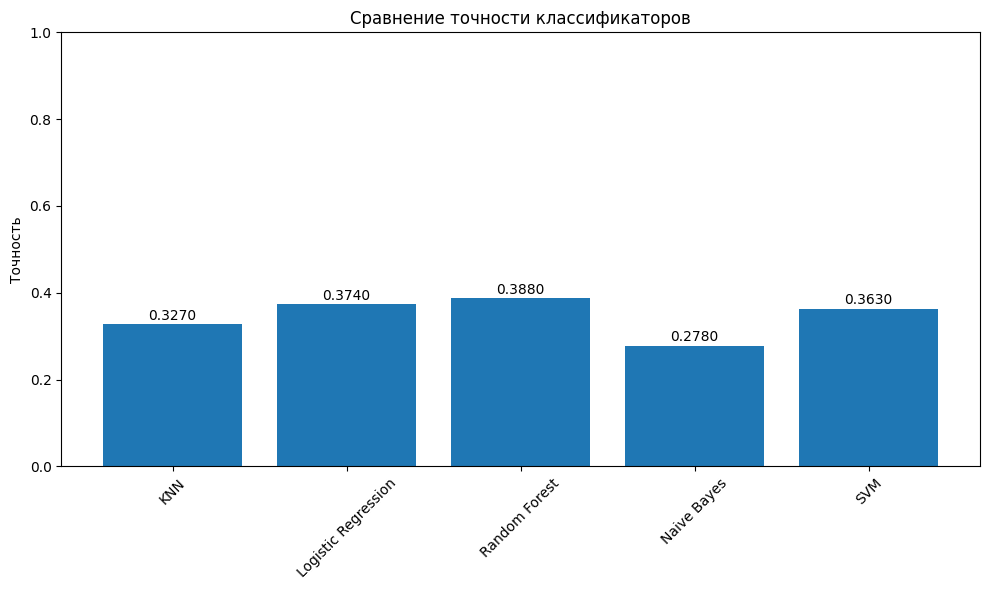

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Уменьшаем размерность с помощью PCA для ускорения работы классификаторов
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train_sample)
x_test_pca = pca.transform(x_test_sample)

print(f"Объясненная дисперсия PCA: {np.sum(pca.explained_variance_ratio_):.4f}")

classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=best_k),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='linear', random_state=42)
}

results = {}

for name, clf in classifiers.items():
    print(f"\nОбучение {name}...")
    clf.fit(x_train_pca, y_train_sample)
    y_pred = clf.predict(x_test_pca)
    accuracy = accuracy_score(y_test_sample, y_pred)
    results[name] = accuracy
    print(f"{name} точность: {accuracy:.4f}")

# Сравнение результатов
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Сравнение точности классификаторов')
plt.ylabel('Точность')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

**10. Анализ сбалансированности классов**

In [21]:
# Анализ сбалансированности
class_counts = np.bincount(y_train_flat)
class_proportions = class_counts / len(y_train_flat)

print("Пропорции классов:")
for i, (class_name, proportion) in enumerate(zip(class_names, class_proportions)):
    print(f"{class_name}: {proportion:.3f}")

# Поскольку классы сбалансированы, дополнительные методы не требуются
print("\nВывод: классы сбалансированы, дополнительные методы обработки несбалансированности не требуются")

Пропорции классов:
airplane: 0.100
automobile: 0.100
bird: 0.100
cat: 0.100
deer: 0.100
dog: 0.100
frog: 0.100
horse: 0.100
ship: 0.100
truck: 0.100

Вывод: классы сбалансированы, дополнительные методы обработки несбалансированности не требуются


**11. Анализ корреляций**

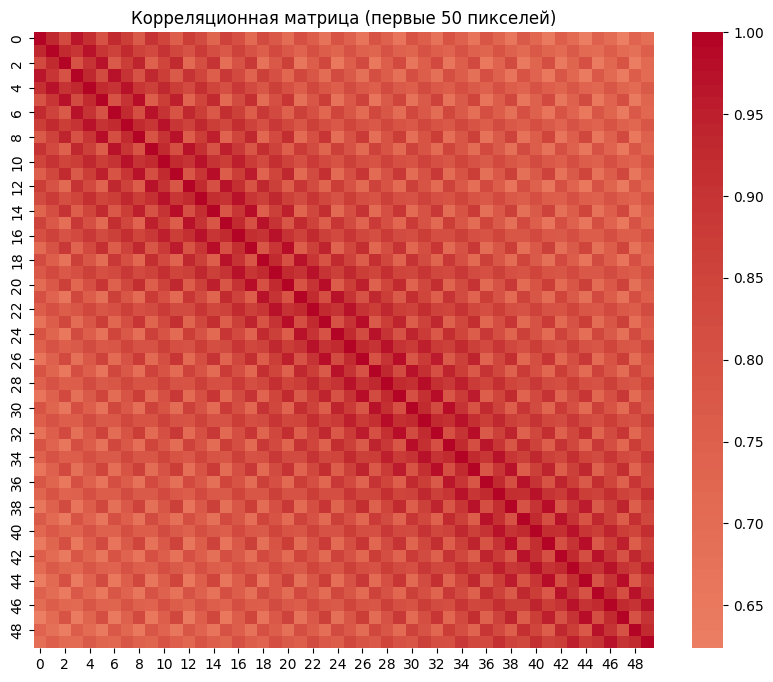

Количество высококоррелированных пар (|r| > 0.95): 1190


In [23]:
# Анализ корреляций между пикселями (на примере небольшой подвыборки)
pixel_sample = x_train_flat_normalized[:1000]  # Берем подвыборку для вычисления корреляций

# Вычисляем корреляционную матрицу
correlation_matrix = np.corrcoef(pixel_sample.T)

# Визуализируем небольшую часть корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[:50, :50], cmap='coolwarm', center=0)
plt.title('Корреляционная матрица (первые 50 пикселей)')
plt.show()

# Анализ высококоррелированных признаков
high_corr_indices = np.where(np.abs(correlation_matrix) > 0.95)
high_corr_pairs = [(i, j) for i, j in zip(high_corr_indices[0], high_corr_indices[1]) if i < j]
print(f"Количество высококоррелированных пар (|r| > 0.95): {len(high_corr_pairs)}")

В случае изображений исключение коррелированных пикселей нецелесообразно, так как помимо информации, которую несёт каждый отдельный пиксель, их взаимосвязь также несёт связь

**Ключевые выводы:**

CIFAR-10 - сложный dataset для классических методов ML из-за низкого разрешения и высокой вариативности

Классы сбалансированы, что упрощает задачу классификации

Для достижения *state-of-the-art* результатов необходимы глубокие нейронные сети